In [1]:
import geometry
import scale_transform
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import platonics
from segment_anything import sam_model_registry, SamPredictor
import sys
import segmentfunction
import utils
import math
import time
import tqdm


done


(128, 128, 128)


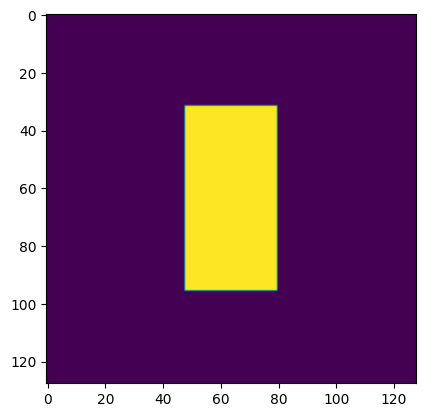

In [2]:
# configuration

starttime = time.time()
checkpointfilepath = r"checkpoints/sam_vit_h_4b8939.pth"
num_slices = 20
transform_list = platonics.get_cube_transforms()

test_1 = np.zeros((128, 128, 128))
test_1[32:96, 48:80, 32:96] = 200
test_2=np.ones((128,128,128))
for i in range(128):
    for j in range(128):
        for k in range(128):
            if ((i-64)**2+(j-64)**2+(k-64)**2)**0.5>50:
                test_2[i,j,k]=0
                

plt.imshow(test_1[:,:,64])

image = test_1
print(image.shape)

In [3]:
def get_prompt_slices(image, dirpath):
    slices_list = []
    for a, t in enumerate(transform_list):
        transformed_img = scale_transform.global_to_local(image, t)
        slice_transformed_img = transformed_img[:,:,transformed_img.shape[2]//2]
        cv2.imwrite(f'{dirpath}/slice_{a}.png', slice_transformed_img)

        slice_info = dict()
        slice_info['idx'] = transformed_img.shape[2]//2
        slice_info['transform'] = t
        slice_info['shape'] = transformed_img.shape
        slices_list.append(slice_info)    

    return slices_list

def get_line_segments(slices_list, pos_polylines_slices, neg_polylines_slices):
    pos_seg = []
    neg_seg = []

    for i, s in enumerate(slices_list):
        idx = s['idx']
        shape = s['shape']
        transform_curr = s['transform']
        print(i)

        for line in pos_polylines_slices[i]:
            global_line = []
            for point in line:
                scaled_point = scale_transform.scale_forward(point[:2] + [idx], shape)
                transformed_point = scale_transform.coord_to_index(scaled_point, transform_curr, shape)
                global_line.append(transformed_point)
            for j in range(len(global_line) - 1):
                pos_seg.append([global_line[j], global_line[j + 1]])

        for line in neg_polylines_slices[i]:
            if i == 1:
                print(line)
            global_line = []
            for point in line:
                scaled_point = scale_transform.scale_forward(point[:2] + [idx], shape)
                transformed_point = scale_transform.coord_to_index(scaled_point, transform_curr, shape)
                global_line.append(transformed_point)
            for j in range(len(global_line) - 1):
                neg_seg.append([global_line[j], global_line[j + 1]])
    
    return pos_seg, neg_seg

def get_intersections(matrix_shape, pos_seg, neg_seg, t, z):
    # calculate intersection points
    pos_intersects = []
    neg_intersects = []

    for p in pos_seg:
        point_1 = scale_transform.scale_backward(scale_transform.index_to_coord(p[0], t, matrix_shape), matrix_shape)
        point_2 = scale_transform.scale_backward(scale_transform.index_to_coord(p[1], t, matrix_shape), matrix_shape)

        intersection = scale_transform.get_intersection_point(point_1, point_2, z)
        if intersection:
            pos_intersects.append(intersection[:2])

    for n in neg_seg:
        point_1 = scale_transform.scale_backward(scale_transform.index_to_coord(n[0], t, matrix_shape), matrix_shape)
        point_2 = scale_transform.scale_backward(scale_transform.index_to_coord(n[1], t, matrix_shape), matrix_shape)

        intersection = scale_transform.get_intersection_point(point_1, point_2, z)
        if intersection:
            neg_intersects.append(intersection[:2])
    
    return pos_intersects, neg_intersects

def normalize (image):
    image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
    image = image.astype(np.uint8)
    stacked = np.stack([image, image, image], axis=2)
    return stacked


In [4]:
# get prompt slices
folder = r"intermediates"

# image = utils.load3dmatrix(folder)
# print(image.shape)
# image = utils.padtocube(image)

slices_list = get_prompt_slices(image, folder)

In [5]:
print(image.shape)

(128, 128, 128)


In [6]:
# given json with polylines
# parse
with open(folder + '/prompts.json', 'r') as file:
    prompt_points = json.load(file)
pos_polylines_slices = []
neg_polylines_slices = []

for prompt in prompt_points:
    pos_polylines_slices.append(prompt['pos_polylines'])
    neg_polylines_slices.append(prompt['neg_polylines'])

# get pos, neg line segments
pos_seg, neg_seg = get_line_segments(slices_list, pos_polylines_slices, neg_polylines_slices)

0
1
2
3


In [7]:
print(pos_seg)

[[array([121., 101., 128.]), array([107., 103.,  82.])], [array([107., 103.,  82.]), array([ 97., 120.,  90.])], [array([ 97., 120.,  90.]), array([111., 116., 135.])], [array([111., 116., 135.]), array([120., 103., 131.])], [array([122., 133.,  94.]), array([127., 131., 116.])], [array([127., 131., 116.]), array([100.,  90., 125.])], [array([100.,  90., 125.]), array([ 96.,  94., 100.])], [array([ 96.,  94., 100.]), array([122., 133.,  93.])], [array([143.,  97., 110.]), array([135., 125.,  92.])], [array([135., 125.,  92.]), array([ 80., 121., 109.])], [array([ 80., 121., 109.]), array([ 89.,  99., 123.])], [array([ 89.,  99., 123.]), array([131.,  99., 112.])], [array([93., 84., 95.]), array([101., 129., 126.])], [array([101., 129., 126.]), array([125., 132., 122.])], [array([125., 132., 122.]), array([121.,  90.,  92.])], [array([121.,  90.,  92.]), array([94., 87., 97.])]]


In [8]:
# initialize the model
sam_checkpoint = checkpointfilepath
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  122.20725951881793
min points =  102.79420769885323


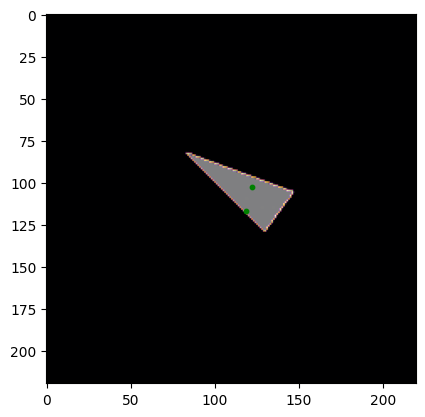

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  123.48396085149831
min points =  89.19335794681753


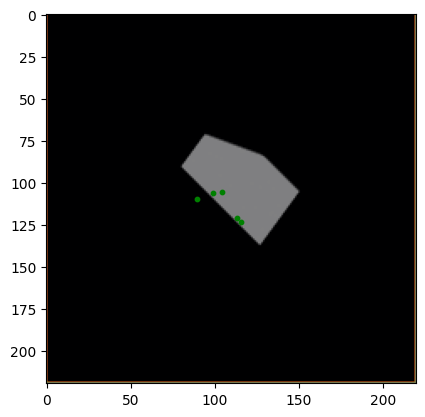

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  126.744630554586
min points =  86.17346511955819


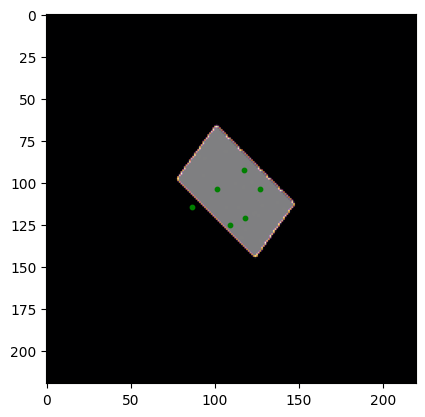

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  136.11753664221527
min points =  94.90610781618122


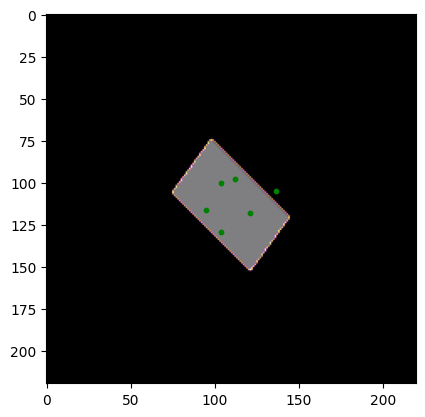

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  133.412959394325
min points =  97.72059343251013


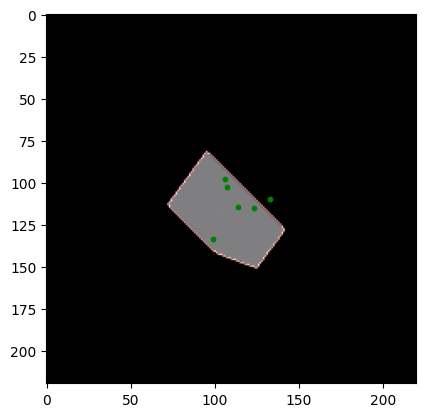

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  100.50168363668459
min points =  98.04904405189188


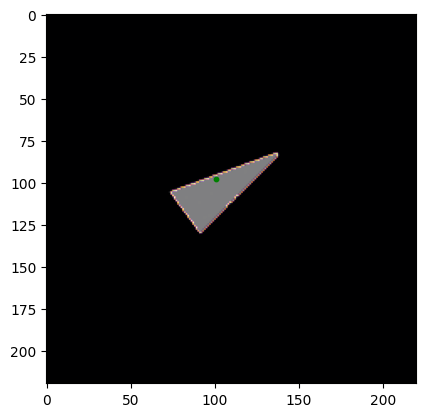

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  131.2070841016578
min points =  83.61030794712714


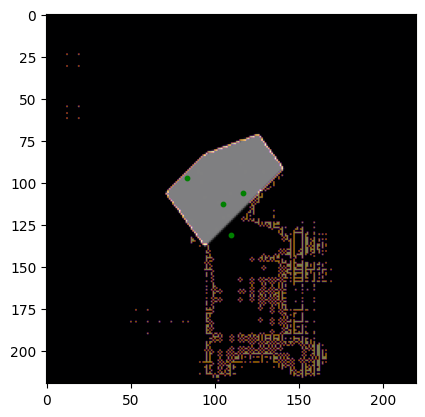

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  138.20737268352877
min points =  87.2846027559723


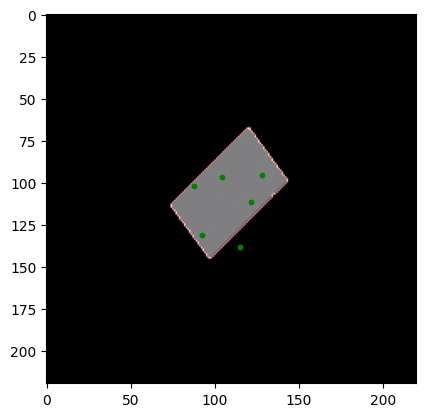

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  127.10110585190205
min points =  82.88198241908398


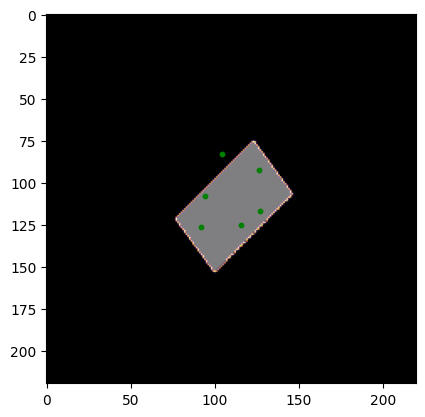

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  128.39391262786742
min points =  90.24228584230832


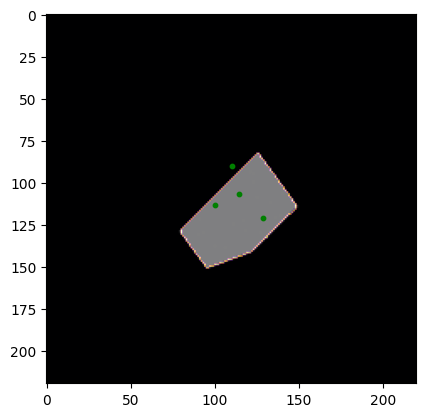

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  121.41674126104787
min points =  106.87409900170582


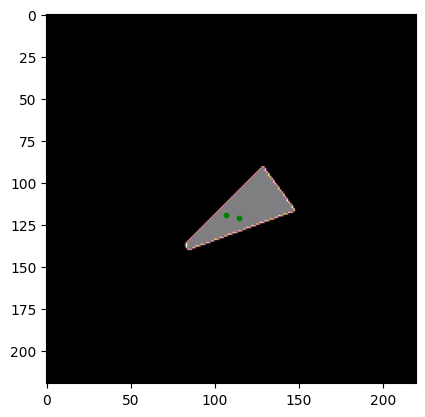

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  112.4306262815635
min points =  94.67099861924811


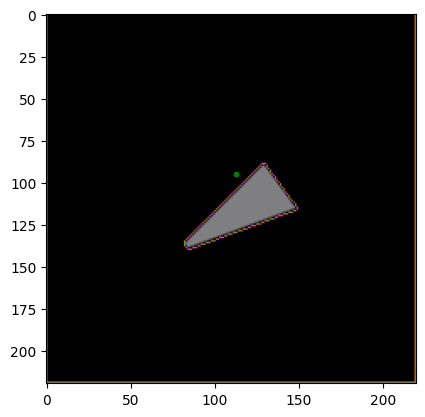

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  126.53568597468086
min points =  95.22435527882566


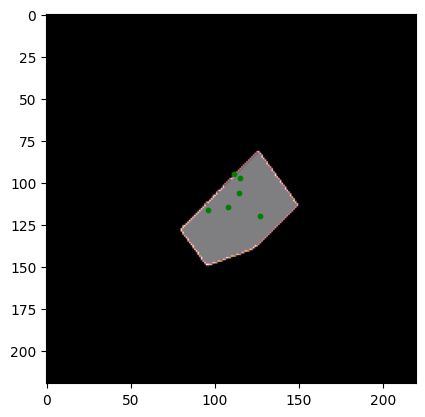

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  125.98474335363535
min points =  87.31665075701659


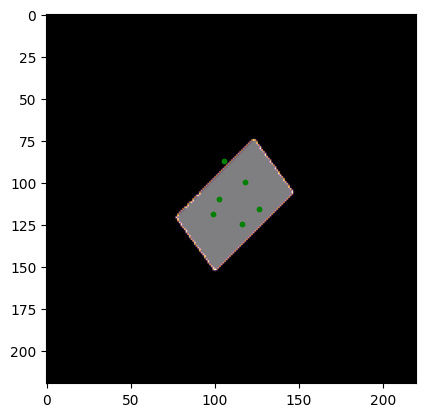

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  138.29794135482877
min points =  95.96442966476039


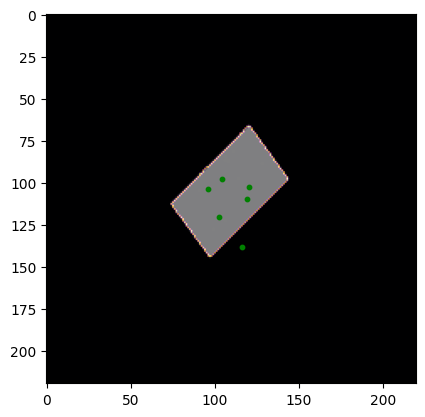

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  131.93974457313502
min points =  94.20895843515326


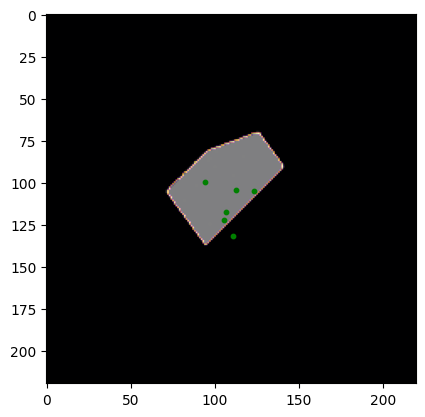

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  134.27619751709736
min points =  98.97416257301005


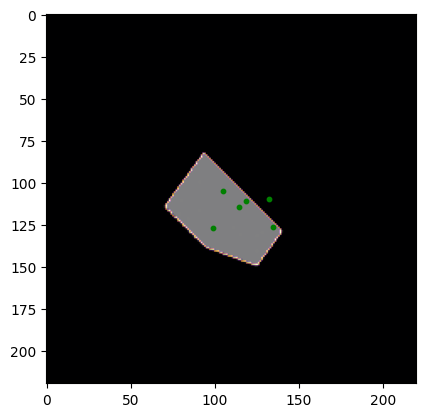

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  135.96322716895554
min points =  89.7684775135842


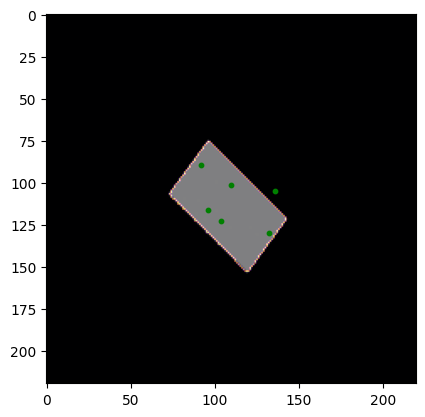

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  133.48467537510726
min points =  89.37822202663241


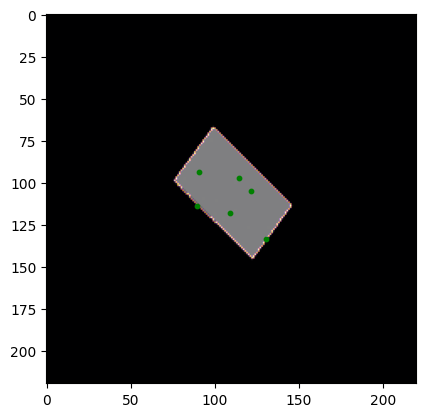

max image =  255
min image =  0
max boundary =  1
min boundary =  0
max points =  118.88062976267808
min points =  92.05771403424167


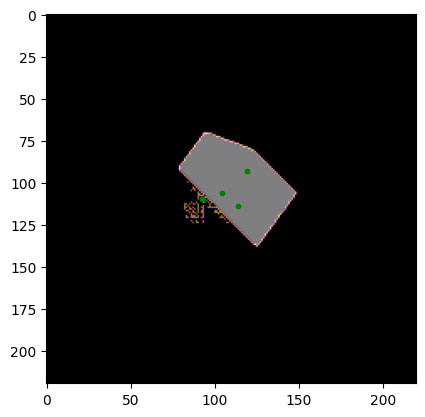

[array([0.14171325, 0.28342649, 0.28342649]), array([0.14696188, 0.27817785, 0.27817785]), array([0.15221052, 0.27292921, 0.27292921]), array([0.15745916, 0.26768057, 0.26768057]), array([0.14171325, 0.28009899, 0.27100808]), array([0.14696188, 0.27485035, 0.26575944]), array([0.15221052, 0.26960171, 0.2605108 ]), array([0.15745916, 0.26435307, 0.25526216]), array([0.1627078 , 0.25910443, 0.25001352]), array([0.14171325, 0.27677148, 0.25858967]), array([0.14696188, 0.27152284, 0.25334103]), array([0.15221052, 0.26627421, 0.24809239]), array([0.15745916, 0.26102557, 0.24284375]), array([0.1627078 , 0.25577693, 0.23759511]), array([0.16795644, 0.25052829, 0.23234647]), array([0.17320508, 0.24527965, 0.22709783]), array([0.14171325, 0.27344398, 0.24617125]), array([0.14696188, 0.26819534, 0.24092261]), array([0.15221052, 0.2629467 , 0.23567398]), array([0.15745916, 0.25769806, 0.23042534]), array([0.1627078 , 0.25244943, 0.2251767 ]), array([0.16795644, 0.24720079, 0.21992806]), array([0.

In [9]:
# BIG forloop
prompting_slices_dict = dict()
count = 0
allpoints = []

for t in transform_list:
    transformed_img = scale_transform.global_to_local(image, t)
    matrix_shape = transformed_img.shape
    
    z_coord_list = np.linspace(0, transformed_img.shape[2], num_slices + 1, endpoint=False, dtype=int)[1:]  

    for z in z_coord_list:
        # get the slice of the rotated array
        slice_transformed_img = transformed_img[:,:,z]
        slice_shape = slice_transformed_img.shape
        
        pos_intersects, neg_intersects = get_intersections(matrix_shape, pos_seg, neg_seg, t, z)
        # print("posintersects = ", pos_intersects)
        # print("negintersects = ", neg_intersects)

        # maybe we dont need
        if len(pos_intersects) != 0:
            prompt = [pos_intersects, neg_intersects]
            for i in range(len(prompt)):
                for j in range(len(prompt[i])):
                    prompt[i][j] = (prompt[i][j][1], prompt[i][j][0])
            points, boundary = segmentfunction.segment(predictor, normalize(slice_transformed_img), 0, prompt)
            pointstobeconverted = []
            for a in range(points.shape[0]):
                for b in range(points.shape[1]):
                    if points[a,b] == 1:
                        pointstobeconverted.append([a,b,z])
            # print(pointstobeconverted)
            
            convertedpoints = [scale_transform.index_to_coord(p, t, matrix_shape) for p in pointstobeconverted]
            for i in convertedpoints:
                # print(i)
                # print(type(i))
                allpoints.append(i)

print(allpoints)



In [12]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [13]:
pcd = o3d.geometry.PointCloud()
n = np.zeros((len(allpoints), 3))
for i in range(len(allpoints)):
    n[i] = allpoints[i]
pcd.points = o3d.utility.Vector3dVector(n)
print("Time taken = ", time.time()-starttime)
o3d.visualization.draw_geometries([pcd], window_name="Point Cloud")


Time taken =  153.18500065803528
